In [247]:
import os
import numpy as np
import scipy.sparse as sp
import qiskit
from qiskit.wrapper.jupyter import *
from qiskit.transpiler._parallel import parallel_map
from collections import OrderedDict
import matplotlib.pyplot as plt
from qiskit.tools.visualization import circuit_drawer, matplotlib_circuit_drawer
from matplotlib.ticker import MaxNLocator
%load_ext Cython
%matplotlib inline

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [2]:
from matplotlib.ticker import MaxNLocator

def wspy(G, ax=None, cmap='viridis', fig_size=(5,5), return_plt=False):
    Gc = G.tocoo()
    new_ax = False
    if ax is None:
        new_ax = True
        fig, ax = plt.subplots(1,1,figsize=fig_size)
    sc = ax.scatter(Gc.row, G.shape[1]-Gc.col-1, c=Gc.data.real, 
                    s=100, marker='s',
                   edgecolors='none', 
                    clip_on=False,
                   cmap=cmap)
    ax.set_facecolor('#f6f6f6')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.xaxis.tick_top()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ylab = ax.get_xticks().tolist()
    new_ylab = [int((G.shape[0]-kk-1)) for kk in ylab]
    ax.set_yticklabels(new_ylab)
    if new_ax:
        cbaxes = fig.add_axes([1, 0.15, 0.05, 0.7]) 
        cb = plt.colorbar(sc, cax = cbaxes)
    if return_plt == True:
        return sc

In [3]:
%%cython --cplus
import numpy as np
cimport numpy as cnp
cimport cython
from libc.stdint cimport int64_t
from libcpp.algorithm cimport sort
from libcpp.vector cimport vector
cnp.import_array()

cdef extern from "numpy/arrayobject.h" nogil:
    void PyArray_ENABLEFLAGS(cnp.ndarray arr, int flags)
    void PyDataMem_FREE(void * ptr)
    void PyDataMem_RENEW(void * ptr, size_t size)
    void PyDataMem_NEW_ZEROED(size_t size, size_t elsize)
    void PyDataMem_NEW(size_t size)

#Struct used for arg sorting
cdef struct _int_pair:
    int data
    int idx

#Struct used for weighted arg sorting
cdef struct _weighted_int_pair:
    int data
    int idx
    int weight

ctypedef _int_pair int_pair
ctypedef _weighted_int_pair weighted_int_pair
ctypedef int (*cfptr)(int_pair, int_pair)
ctypedef int (*wptr)(weighted_int_pair, weighted_int_pair)

@cython.boundscheck(False)
@cython.wraparound(False)
cdef int int_sort(int_pair x, int_pair y):
    return x.data < y.data

@cython.boundscheck(False)
@cython.wraparound(False)
cdef int weighted_int_low_sort(weighted_int_pair x, 
                           weighted_int_pair y):
    if x.data != y.data:
        return x.data < y.data
    elif x.weight != y.weight:
        return x.weight < y.weight
    else:
        return 0
    
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int weighted_int_high_sort(weighted_int_pair x, 
                           weighted_int_pair y):
    if x.data != y.data:
        return x.data < y.data
    elif x.weight != y.weight:
        return x.weight > y.weight
    else:
        return 0


@cython.boundscheck(False)
@cython.wraparound(False)
cdef int * _max_row_weights(
        int * data,
        int * inds,
        int * ptrs,
        int ncols):
    """
    Finds the largest abs value in each matrix column
    and the max. total number of elements in the cols (given by weights[-1]).

    Here we assume that the user already took the ABS value of the data.
    This keeps us from having to call abs over and over.

    """
    cdef int * weights = <int *>PyDataMem_NEW((ncols+1)*sizeof(int))
    cdef int ln, mx, ii, jj
    cdef int weight, current
    mx = 0
    for jj in range(ncols):
        ln = (ptrs[jj + 1] - ptrs[jj])
        if ln > mx:
            mx = ln

        weight = data[ptrs[jj]]
        for ii in range(ptrs[jj] + 1, ptrs[jj + 1]):
            current = data[ii]
            if current > weight:
                weight = current

        weights[jj] = weight

    weights[ncols] = mx
    return weights
    
    
@cython.boundscheck(False)
@cython.wraparound(False)
cdef int * int_argsort(int * x, int nrows):
    cdef vector[int_pair] pairs
    cdef cfptr cfptr_ = &int_sort
    cdef size_t kk
    pairs.resize(nrows)
    for kk in range(nrows):
        pairs[kk].data = x[kk]
        pairs[kk].idx = kk
    
    sort(pairs.begin(),pairs.end(),cfptr_)
    cdef int * out = <int *>PyDataMem_NEW(nrows *sizeof(int))
    for kk in range(nrows):
        out[kk] = pairs[kk].idx
    return out


@cython.boundscheck(False)
@cython.wraparound(False)
cdef int * weighted_int_argsort(int * data, 
                                int * inds,
                                int * ptr,
                                int * x, int nrows):
    cdef vector[weighted_int_pair] pairs
    cdef wptr wptr_ = &weighted_int_low_sort
    cdef size_t kk
    
    cdef int * weights = _max_row_weights(data,
                                              inds,
                                              ptr,
                                            nrows)
    pairs.resize(nrows)
    for kk in range(nrows):
        pairs[kk].data = x[kk]
        pairs[kk].idx = kk
        pairs[kk].weight = weights[kk]
    
    sort(pairs.begin(),pairs.end(),wptr_)
    cdef int * out = <int *>PyDataMem_NEW(nrows *sizeof(int))
    for kk in range(nrows):
        out[kk] = pairs[kk].idx
    PyDataMem_FREE(weights)
    return out



@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int[::1] _node_degrees(int[::1] ind, int[::1] ptr,
        unsigned int num_rows):

    cdef size_t ii, jj
    cdef int[::1] degree = np.zeros(num_rows, dtype=np.int32)

    for ii in range(num_rows):
        degree[ii] = ptr[ii + 1] - ptr[ii]
        for jj in range(ptr[ii], ptr[ii + 1]):
            if ind[jj] == ii:
                # add one if the diagonal is in row ii
                degree[ii] += 1
                break

    return degree



cdef inline int int_max(int x, int y):
    return x ^ ((x ^ y) & -(x < y))

@cython.boundscheck(False)
@cython.wraparound(False)
def sparse_bandwidth(
        int[::1] idx,
        int[::1] ptr,
        int nrows):
    """
    Calculates the max (mb), lower(lb), and upper(ub) bandwidths of a
    csr_matrix.
    """
    cdef int ldist
    cdef int lb = -nrows
    cdef int ub = -nrows
    cdef int mb = 0
    cdef size_t ii, jj

    for ii in range(nrows):
        for jj in range(ptr[ii], ptr[ii + 1]):
            ldist = ii - idx[jj]
            lb = int_max(lb, ldist)
            ub = int_max(ub, -ldist)
            mb = int_max(mb, ub + lb + 1)

    return mb, lb, ub

@cython.boundscheck(False)
@cython.wraparound(False)
def weighted_profile(int[::1] data,
                    int[::1] idx,
                    int[::1] ptr,
                    int nrows):
    cdef size_t ii, jj, 
    cdef int temp, weighted_dist=0
    cdef int64_t pro = 0
    for ii in range(nrows):
        temp = 0
        for jj in range(ptr[ii], ptr[ii + 1]):
            weighted_dist = (idx[jj] - ii)*data[jj]
            temp = int_max(temp, weighted_dist)
        pro += temp
    return pro


@cython.boundscheck(False)
@cython.wraparound(False)
def reverse_cuthill_mckee(int[::1] ind, int[::1] ptr, int num_rows):
    """
    Reverse Cuthill-McKee ordering of a sparse csr or csc matrix.
    """
    cdef unsigned int N = 0, N_old, seed, level_start, level_end
    cdef unsigned int zz, i, j, ii, jj, kk, ll, level_len, temp, temp2
    cdef cnp.ndarray[int, ndim=1] order = np.zeros(num_rows, dtype=np.int32)
    cdef int[::1] degree = _node_degrees(ind, ptr, num_rows)
    cdef int * inds = int_argsort(&degree[0], num_rows)
    cdef int * rev_inds = int_argsort(inds, num_rows)
    cdef int * temp_degrees = NULL
    
    cdef cfptr cfptr_ = &int_sort
    cdef vector[int_pair] pairs

    # loop over zz takes into account possible disconnected graph.
    for zz in range(num_rows):
        if inds[zz] != -1:   # Do BFS with seed=inds[zz]
            seed = inds[zz]
            order[N] = seed
            N += 1
            inds[rev_inds[seed]] = -1
            level_start = N - 1
            level_end = N

            while level_start < level_end:
                for ii in range(level_start, level_end):
                    i = order[ii]
                    N_old = N

                    # add unvisited neighbors
                    for jj in range(ptr[i], ptr[i + 1]):
                        # j is node number connected to i
                        j = ind[jj]
                        if inds[rev_inds[j]] != -1:
                            inds[rev_inds[j]] = -1
                            order[N] = j
                            N += 1
                    
                    # Do the low -> high sorting here
                    pairs.resize((N-N_old))
                    level_len = 0
                    for kk in range(N_old, N):
                        pairs[level_len].data = degree[order[kk]]
                        pairs[level_len].idx = order[N_old+level_len]
                        level_len += 1
                    
                    sort(pairs.begin(),pairs.end(),cfptr_)
                    
                    for kk in range(level_len):
                        order[N_old+kk] = pairs[kk].idx

                # set next level start and end ranges
                level_start = level_end
                level_end = N

        if N == num_rows:
            break
    PyDataMem_FREE(inds)
    PyDataMem_FREE(rev_inds)
    PyDataMem_FREE(temp_degrees)
    # return reversed order for RCM ordering
    return order[::-1]


@cython.boundscheck(False)
@cython.wraparound(False)
def weighted_reverse_cuthill_mckee(int[::1] data, 
                                   int[::1] ind, 
                                   int[::1] ptr, 
                                   int num_rows):
    """
    Reverse Cuthill-McKee ordering of a sparse csr or csc matrix.
    """
    cdef unsigned int N = 0, N_old, seed, level_start, level_end
    cdef unsigned int zz, i, j, ii, jj, kk, ll, level_len, temp, temp2
    cdef cnp.ndarray[int, ndim=1] order = np.zeros(num_rows, dtype=np.int32)
    cdef int[::1] degree = _node_degrees(ind, ptr, num_rows)
    cdef int * inds = weighted_int_argsort(&data[0],
                                           &ind[0],
                                           &ptr[0],
                                           &degree[0], num_rows)
    cdef int * rev_inds = int_argsort(inds, num_rows)
    
    cdef wptr wptr_ = &weighted_int_high_sort
    cdef vector[weighted_int_pair] pairs

    # loop over zz takes into account possible disconnected graph.
    for zz in range(num_rows):
        if inds[zz] != -1:   # Do BFS with seed=inds[zz]
            seed = inds[zz]
            order[N] = seed
            N += 1
            inds[rev_inds[seed]] = -1
            level_start = N - 1
            level_end = N

            while level_start < level_end:
                for ii in range(level_start, level_end):
                    i = order[ii]
                    N_old = N

                    # add unvisited neighbors
                    for jj in range(ptr[i], ptr[i + 1]):
                        # j is node number connected to i
                        j = ind[jj]
                        if inds[rev_inds[j]] != -1:
                            inds[rev_inds[j]] = -1
                            order[N] = j
                            N += 1

                    # Do the low -> high sorting here
                    pairs.resize((N-N_old))
                    level_len = 0
                    for kk in range(N_old, N):
                        pairs[level_len].data = degree[order[kk]]
                        pairs[level_len].idx = order[N_old+level_len]
                        pairs[level_len].weight = data[order[kk]]
                        level_len += 1
                    
                    sort(pairs.begin(),pairs.end(),wptr_)
                    for kk in range(level_len):
                        order[N_old+kk] = pairs[kk].idx

                # set next level start and end ranges
                level_start = level_end
                level_end = N

        if N == num_rows:
            break
    PyDataMem_FREE(inds)
    PyDataMem_FREE(rev_inds)
    # return reversed order for RCM ordering
    return order[::-1]


def test_double_sort(int[::1] data, int[::1] degree, int[::1] order):
    
    cdef wptr wptr_ = &weighted_int_low_sort
    cdef vector[weighted_int_pair] pairs
    cdef length = data.shape[0]
    cdef size_t kk
    
    pairs.resize(length)
    for kk in range(length):
        pairs[kk].data = degree[kk]
        pairs[kk].idx = order[kk]
        pairs[kk].weight = data[kk]
    
    sort(pairs.begin(),pairs.end(),wptr_)
    
    for kk in range(length):
        degree[kk] = pairs[kk].data
        order[kk] = pairs[kk].idx
        data[kk] = pairs[kk].weight


In [4]:
%%cython --cplus
import numpy as np
cimport numpy as cnp
cimport cython
cnp.import_array()

@cython.boundscheck(False)
@cython.wraparound(False)
def sparse_permute(
        cnp.ndarray[cython.numeric, ndim=1] data,
        int[::1] idx,
        int[::1] ptr,
        int nrows,
        int ncols,
        cnp.ndarray[int, ndim=1] rperm,
        cnp.ndarray[int, ndim=1] cperm,
        int flag):
    """
    Permutes the rows and columns of a sparse CSR or CSC matrix according to
    the permutation arrays rperm and cperm, respectively.
    Here, the permutation arrays specify the new order of the rows and columns.
    i.e. [0,1,2,3,4] -> [3,0,4,1,2].
    """
    cdef size_t ii, jj, kk, k0, nnz
    cdef cnp.ndarray[cython.numeric] new_data = np.zeros_like(data)
    cdef cnp.ndarray[int] new_idx = np.zeros_like(idx)
    cdef cnp.ndarray[int] new_ptr = np.zeros_like(ptr)
    cdef cnp.ndarray[int] perm_r
    cdef cnp.ndarray[int] perm_c
    cdef cnp.ndarray[int] inds

    if flag == 0:  # CSR matrix
        if rperm.shape[0] != 0:
            inds = np.argsort(rperm).astype(np.int32)
            perm_r = np.arange(rperm.shape[0], dtype=np.int32)[inds]

            for jj in range(nrows):
                ii = perm_r[jj]
                new_ptr[ii + 1] = ptr[jj + 1] - ptr[jj]

            for jj in range(nrows):
                new_ptr[jj + 1] = new_ptr[jj+1] + new_ptr[jj]

            for jj in range(nrows):
                k0 = new_ptr[perm_r[jj]]
                for kk in range(ptr[jj], ptr[jj + 1]):
                    new_idx[k0] = idx[kk]
                    new_data[k0] = data[kk]
                    k0 = k0 + 1

        if cperm.shape[0] != 0:
            inds = np.argsort(cperm).astype(np.int32)
            perm_c = np.arange(cperm.shape[0], dtype=np.int32)[inds]
            nnz = new_ptr[new_ptr.shape[0] - 1]
            for jj in range(nnz):
                new_idx[jj] = perm_c[new_idx[jj]]

    elif flag == 1:  # CSC matrix
        if cperm.shape[0] != 0:
            inds = np.argsort(cperm).astype(np.int32)
            perm_c = np.arange(cperm.shape[0], dtype=np.int32)[inds]

            for jj in range(ncols):
                ii = perm_c[jj]
                new_ptr[ii + 1] = ptr[jj + 1] - ptr[jj]

            for jj in range(ncols):
                new_ptr[jj + 1] = new_ptr[jj + 1] + new_ptr[jj]

            for jj in range(ncols):
                k0 = new_ptr[perm_c[jj]]
                for kk in range(ptr[jj], ptr[jj + 1]):
                    new_idx[k0] = idx[kk]
                    new_data[k0] = data[kk]
                    k0 = k0 + 1

        if rperm.shape[0] != 0:
            inds = np.argsort(rperm).astype(np.int32)
            perm_r = np.arange(rperm.shape[0], dtype=np.int32)[inds]
            nnz = new_ptr[new_ptr.shape[0] - 1]
            for jj in range(nnz):
                new_idx[jj] = perm_r[new_idx[jj]]

    return new_data, new_idx, new_ptr

In [5]:
data = np.array([3,1,5,4,6], dtype=np.int32)
deg = np.array([1,1,1,1,1],dtype=np.int32)
order = np.arange(5,dtype=np.int32)
test_double_sort(data,deg,order)

print(data)
print(deg)
print(order)

[1 3 4 5 6]
[1 1 1 1 1]
[1 0 3 2 4]


In [6]:
def qasm_gate_count(qasm):
    gate_count = 0
    cx_count = 0
    for line in qasm.split('\n'):
        if len(line):
            is_gate = 1
            for kk in ['include', 'qreg', 'creg', 'barrier', 'measure', 'OPENQASM']:
                if line.startswith(kk):
                    is_gate = 0
                    break
            if line.startswith('cx'):
                cx_count += 1
            if is_gate:
                gate_count +=1    
    return gate_count, cx_count

In [7]:
import copy
def loco(circuit, weighted=True, in_place=False, verbose=False):
    """Permute qubit labels so that two-qubit gates are
    as local as possible.
    
    Parameters:
        circuit: (qiskit.QuantumCircuit)
            An input quantum circuit
            
    """
    rows = []
    cols = []
    data = []
    qregs = circuit.get_qregs()
    num_qubits = 0
    num_reg = len(qregs.items())
    register_mapping = {}
    for key, value in qregs.items():
        register_mapping[key] = np.arange(value.size)+num_qubits
        num_qubits += value.size
    
    for item in circuit.data:
        n_qubit_gate = len(item.arg)
        if n_qubit_gate == 2:
            if not isinstance(item, qiskit._measure.Measure):
                rows.append(register_mapping[item.arg[0][0].name][item.arg[0][1]])
                cols.append(register_mapping[item.arg[1][0].name][item.arg[1][1]])
                data.append(1)
        elif n_qubit_gate != 1 and item.name != 'barrier':
            raise Exception('Gate is not 1 or two qubits.')
    circ_graph = sp.coo_matrix((data,(rows,cols)), dtype=np.int32, shape=(num_qubits, num_qubits)).tocsr()
    G = circ_graph + circ_graph.T
    
    _, _, ub = sparse_bandwidth(G.indices, G.indptr, G.shape[0])
    pro = weighted_profile(G.data, G.indices, G.indptr, G.shape[0])
    
    if verbose:
        fig, axes = plt.subplots(1,2, figsize=(9,4))
        wspy(G, ax = axes[0])
        print('Orig. bandwidth:', ub)
        print('Orig. weighted profile:', pro)
    
    
    if weighted:
        perm = weighted_reverse_cuthill_mckee(G.data, G.indices, G.indptr, G.shape[0])
    else:
        perm = reverse_cuthill_mckee(G.indices, G.indptr, G.shape[0])
    
    
    new_data, new_ind, new_ptr = sparse_permute(G.data,
                                            G.indices,
                                            G.indptr,
                                            G.shape[0],
                                            G.shape[1],
                                            perm, perm, 0)
    _, _, new_ub = sparse_bandwidth(new_ind, new_ptr, G.shape[0])
    F = sp.csr_matrix((new_data,new_ind,new_ptr), shape = G.shape)
    new_pro = weighted_profile(F.data, F.indices, F.indptr, F.shape[0])
    
    if verbose:
        ws = wspy(F, ax = axes[1], return_plt=True)
        cbaxes = fig.add_axes([0.95, 0.15, 0.02, 0.7]) 
        cb = plt.colorbar(ws, cax = cbaxes)
        print('New bandwidth:', new_ub)
        print('Bandwidth reduction', np.round((ub-new_ub)/ub*100,2), '%')
        print('New weighted profile:', new_pro)
        print('Profile reduction', np.round((pro-new_pro)/pro*100,2), '%')
        #plt.savefig('optim.pdf')
        plt.show(fig)
    
    rev_idx = np.argsort(perm)
    
    if num_reg == 1:
        if in_place:
            out_circuit = circuit
        else:
            out_circuit = copy.deepcopy(circuit)
            
        for item in out_circuit.data:
            n_qubit_gate = len(item.arg)
            if n_qubit_gate == 1:
                item.arg[0] = (item.arg[0][0],rev_idx[item.arg[0][1]])
            elif n_qubit_gate == 2:
                if not isinstance(item, qiskit._measure.Measure):
                    item.arg[0] = (item.arg[0][0], rev_idx[item.arg[0][1]])
                    item.arg[1] = (item.arg[1][0], rev_idx[item.arg[1][1]])
                else:
                    item.arg[0] = (item.arg[0][0], rev_idx[item.arg[0][1]])
    
    # QISKit currently does not support interleaving multiple registers, so just replace
    # with a single big one of size num_qubits.
    else:
        out_circuit = copy.deepcopy(circuit)
        # Replace qregs with big reg
        did_update = 0
        new_regs = OrderedDict()
        for key, val in out_circuit.regs.items():
            if isinstance(val, qiskit.QuantumRegister):
                if not did_update:
                    new_regs['q_rcm'] = qiskit.QuantumRegister(8, 'q_rcm')
                    did_update = 1
            else:
                new_regs[key] = val
        out_circuit.regs = new_regs
        
        #Make all new gates point to new reg values
        for item in out_circuit.data:
            n_qubit_gate = len(item.arg)
            if n_qubit_gate == 1:
                item.arg[0] = (new_regs['q_rcm'],rev_idx[register_mapping[item.arg[0][0].name][item.arg[0][1]]])
            elif n_qubit_gate == 2:
                if not isinstance(item, qiskit._measure.Measure):
                    item.arg[0] = (new_regs['q_rcm'], rev_idx[register_mapping[item.arg[0][0].name][item.arg[0][1]]])
                    item.arg[1] = (new_regs['q_rcm'], rev_idx[register_mapping[item.arg[1][0].name][item.arg[1][1]]])
                else:
                    item.arg[0] = (new_regs['q_rcm'], rev_idx[register_mapping[item.arg[0][0].name][item.arg[0][1]]])
        
        

    return out_circuit, perm, (ub-new_ub)/ub, (pro-new_pro)/pro

In [8]:
import math
import scipy.linalg as la
from qiskit.tools.qi.qi import random_unitary_matrix
from qiskit.mapper import two_qubit_kak

def build_qv_circuit(seed, n, depth):
    """Create a quantum program containing model circuits.

    The model circuits consist of layers of Haar random
    elements of SU(4) applied between corresponding pairs
    of qubits in a random bipartition.

    name = leading name of circuits
    n = number of qubits
    depth = ideal depth of each model circuit (over SU(4))

    Return a quantum program.
    """
    q = QuantumRegister(n, "q")
    c = ClassicalRegister(n, "c")
    # Create measurement subcircuit
    qc = QuantumCircuit(q,c)
    # For each layer
    np.random.seed(seed)
    for j in range(depth):
        # Generate uniformly random permutation Pj of [0...n-1]
        perm = np.random.permutation(n)
        # For each pair p in Pj, generate Haar random SU(4)
        # Decompose each SU(4) into CNOT + SU(2) and add to Ci
        for k in range(math.floor(n/2)):
            qubits = [int(perm[2*k]), int(perm[2*k+1])]
            U = random_unitary_matrix(4)
            for gate in two_qubit_kak(U):
                i0 = qubits[gate["args"][0]]
                if gate["name"] == "cx":
                    i1 = qubits[gate["args"][1]]
                    qc.cx(q[i0], q[i1])
                elif gate["name"] == "u1":
                    qc.u1(gate["params"][2], q[i0])
                elif gate["name"] == "u2":
                    qc.u2(gate["params"][1], gate["params"][2],
                                 q[i0])
                elif gate["name"] == "u3":
                    qc.u3(gate["params"][0], gate["params"][1],
                                 gate["params"][2], q[i0])
                elif gate["name"] == "id":
                    pass  # do nothing
    # Create circuit with final measurement
    qc.measure(q,c)
    return qc

# QV Testing

In [9]:
# importing the QISKit
from qiskit import *
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization._circuit_visualization import qx_color_scheme
from qiskit import *


In [79]:
class LNN(object):
    """A fake backend.
    """
    def configuration(self):
        lnn_cmap = [[0,1], [1,0], [1,2], [2,1], [2,3], [3,2]]
        return {
            'name': 'lnn', 'basis_gates': 'u1,u2,u3,cx,id',
            'simulator': False, 'n_qubits': 4,
            'coupling_map': lnn_cmap
        }


In [224]:
def eval_qv(idx, seeds, num, depth, backend, reps=10):
    circ = build_qv_circuit(seeds[idx], num, depth)
    best = np.iinfo(np.int32).max
    qobj = compile([circ]*reps, backend = backend)
    best_idx = None
    for jj in range(reps):   
        qasm = qobj.experiments[jj].header.compiled_circuit_qasm
        tot_gates, cx_gates = qasm_gate_count(qasm)
        if tot_gates < best:
            best = tot_gates
            best_cx = cx_gates
            best_idx = jj
    qobj.experiments = [qobj.experiments[best_idx]]
    best_orig = best
    best_orig_cx = best_cx
    
    loco_circ, perm, bw, pro = loco(circ)
    
    best_loco = None
    best_loco_cx = None
    loco_qobj = None
    best_idx = None
    if bw > 0 or pro > 0:
        best = np.iinfo(np.int32).max
        loco_qobj = compile([loco_circ]*reps, backend = backend)
        for jj in range(reps):   
            qasm = loco_qobj.experiments[jj].header.compiled_circuit_qasm
            tot_gates, cx_gates = qasm_gate_count(qasm)
            if tot_gates < best:
                best = tot_gates
                best_cx = cx_gates
                best_idx = jj
        best_loco = best
        best_loco_cx = best_cx
        loco_qobj.experiments = [loco_qobj.experiments[best_idx]]
        
    return qobj, loco_qobj, [best_orig, best_orig_cx], [best_loco, best_loco_cx]

# LNN

In [225]:
%%qiskit_progress_bar
N = 100
num = 4
depth = 4
seeds = np.random.randint(2**31-1, size=N)
out = parallel_map(eval_qv, np.arange(N), task_args=(seeds, num, depth, LNN()))

In [249]:
qobjs = [out[kk][0] for kk in range(N)]
loco_qobjs = [out[kk][1] for kk in range(N)]
best_orig = np.array([out[kk][2][0] for kk in range(N)])
best_orig_cx = np.array([out[kk][2][1] for kk in range(N)])
best_loco = np.array([out[kk][3][0] for kk in range(N)])
best_loco_cx = np.array([out[kk][3][1] for kk in range(N)])
idx = np.where(best_loco != None)[0]
print(len(idx))
cx_diff = (best_orig_cx[idx]-best_loco_cx[idx])
print(idx)

51
[ 0  1  2  6  8  9 11 17 19 21 31 36 37 38 39 40 42 43 44 45 47 48 49 54
 55 56 61 62 65 66 67 68 70 71 72 73 75 76 77 78 79 81 82 83 84 86 88 90
 93 95 97]


In [303]:
cx_diff = (best_orig_cx[idx]-best_loco_cx[idx])
print([k for k in zip(idx,np.asarray(cx_diff/3,dtype=int))])

[(0, 1), (1, 1), (2, 1), (6, 2), (8, 2), (9, 1), (11, 1), (17, 2), (19, 1), (21, 2), (31, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (42, 2), (43, 1), (44, 1), (45, 1), (47, 2), (48, 2), (49, 1), (54, 1), (55, 2), (56, 1), (61, 2), (62, 2), (65, 1), (66, 1), (67, 1), (68, 1), (70, 1), (71, 1), (72, 2), (73, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (81, 1), (82, 2), (83, 2), (84, 3), (86, 1), (88, 2), (90, 1), (93, 1), (95, 1), (97, 2)]


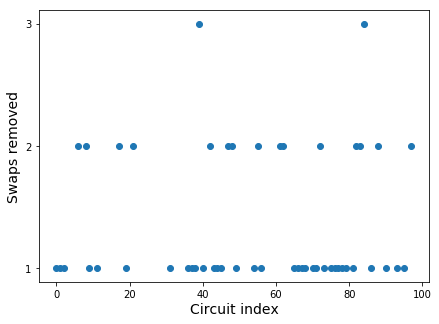

In [248]:
fig, ax = plt.subplots(1,1)
fig.set_figwidth(7)
fig.set_figheight(5)
ax.scatter(idx, cx_diff/3)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel('Circuit index', fontsize=14)
ax.set_ylabel('Swaps removed', fontsize=14);

In [253]:
qasm = qobjs[idx[0]].experiments[0].header.compiled_circuit_qasm

In [279]:
import os
cwd = os.getcwd()
full_path = cwd + '/optimized_circuits/orig/'
full_path

'/Users/paul/Desktop/Github_repos/qiskit-core/optimized_circuits/orig/'

In [280]:
for kk in range(N):
    _qasm = qobjs[kk].experiments[0].header.compiled_circuit_qasm
    with open(full_path+'orig_circuit_idx=%s.qasm' % kk, 'w') as f: 
        for line in _qasm:
            #f.write(line)

In [231]:
orig_res = orig_job.result()

In [232]:
orig_res.get_counts()

{'0000': 191,
 '0001': 21,
 '0010': 67,
 '0011': 194,
 '0100': 30,
 '0101': 6,
 '0110': 33,
 '0111': 99,
 '1000': 56,
 '1001': 15,
 '1010': 38,
 '1011': 81,
 '1100': 59,
 '1101': 43,
 '1110': 28,
 '1111': 63}

In [282]:
orig_path = cwd + '/optimized_circuits/orig/'
optim_path = cwd + '/optimized_circuits/optim/'

In [291]:
orig_circuit = qiskit.load_qasm_file(orig_path+'orig_circuit_idx=84.qasm')
optim_circuit = qiskit.load_qasm_file(optim_path+'optim_circuit_idx=84.qasm')

In [235]:
loco_counts = loco_res.get_counts()
loco_counts

{'0000': 183,
 '0001': 19,
 '0010': 72,
 '0011': 190,
 '0100': 43,
 '0101': 5,
 '0110': 59,
 '0111': 83,
 '1000': 60,
 '1001': 19,
 '1010': 42,
 '1011': 58,
 '1100': 55,
 '1101': 50,
 '1110': 28,
 '1111': 58}

In [287]:
idx[44]

84

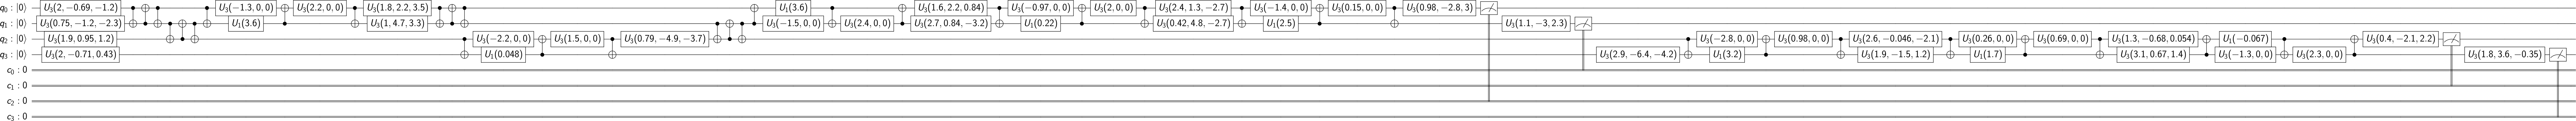

In [292]:
circuit_drawer(qiskit.qobj_to_circuits(qobjs[84])[0])

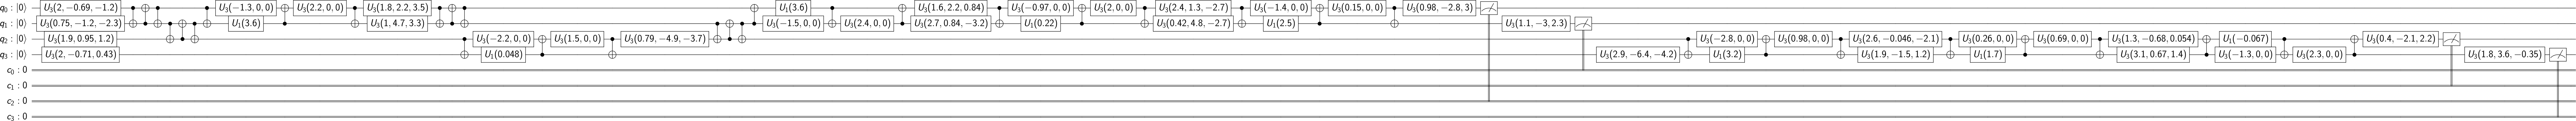

In [293]:
circuit_drawer(orig_circuit)

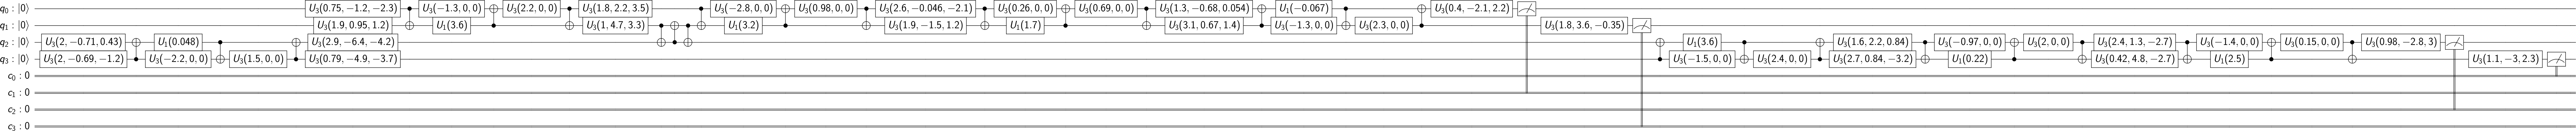

In [294]:
circuit_drawer(qiskit.qobj_to_circuits(loco_qobjs[84])[0])

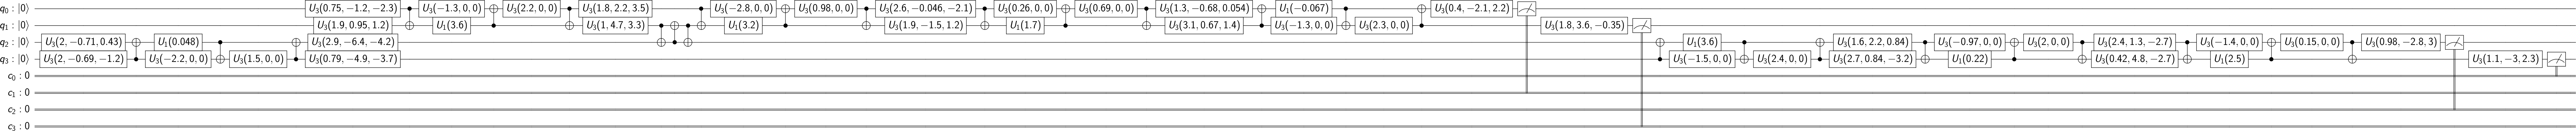

In [295]:
circuit_drawer(optim_circuit)